In [26]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


In [27]:
# Paths
MODELS_FOLDER = os.path.join("data", "DNN_trained_models")
LOG_FILE = os.path.join("data", "DNN_trained_models_docs.csv")
SIM_DATA_FILE = os.path.join("data", "COMSOL", "results_3D_GE_Applied_Current_1MKOH_63_02_1MKOH_input_parameters_DOE_maximin_lhs_processed_003.csv")
FIG_FOLDER = "figures"
os.makedirs(FIG_FOLDER, exist_ok=True)

df = pd.read_csv(SIM_DATA_FILE)
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (2776, 14)


,W_mem [m],W_GDE [m],T [degC],sigmas_MGL370 [S/m],sigmas_SS316L [S/m],eps_H2,eps_O2,v_in_H2 [m/s],v_in_O2 [m/s],p_gas [Pa],i0_ref_O2 [A/m^2],i0_ref_H2 [A/m^2],Time_s,Voltage_V
0,0.000043,0.000553,61.2245,34954900.0,491765.0,0.787301,0.707423,0.004702,0.004975,2584410.0,0.042804,0.032654,0.00000,1.20181
1,0.000043,0.000553,61.2245,34954900.0,491765.0,0.787301,0.707423,0.004702,0.004975,2584410.0,0.042804,0.032654,1.00857,1.78528
2,0.000043,0.000553,61.2245,34954900.0,491765.0,0.787301,0.707423,0.004702,0.004975,2584410.0,0.042804,0.032654,2.01714,1.89538
3,0.000043,0.000553,61.2245,34954900.0,491765.0,0.787301,0.707423,0.004702,0.004975,2584410.0,0.042804,0.032654,3.02571,1.97111
4,0.000043,0.000553,61.2245,34954900.0,491765.0,0.787301,0.707423,0.004702,0.004975,2584410.0,0.042804,0.032654,4.03429,2.03213


In [28]:
input_cols = [
    "W_mem [m]", "W_GDE [m]", "T [degC]", "sigmas_MGL370 [S/m]",
    "sigmas_SS316L [S/m]", "eps_H2", "eps_O2", "v_in_H2 [m/s]",
    "v_in_O2 [m/s]", "p_gas [Pa]", "i0_ref_O2 [A/m^2]", "i0_ref_H2 [A/m^2]"
]

output_col = "Voltage_V"

# Group the dataset by unique parameter sets (i.e., each trial)
grouped = df.groupby(input_cols)
print(f"Total number of trials: {len(grouped)}")


Total number of trials: 200


In [29]:
# Select trial index
trial_index = 100
trial_df = list(grouped)[trial_index][1].copy()

# Define input columns
input_cols = [
    "W_mem [m]", "W_GDE [m]", "T [degC]", "sigmas_MGL370 [S/m]",
    "sigmas_SS316L [S/m]", "eps_H2", "eps_O2", "v_in_H2 [m/s]",
    "v_in_O2 [m/s]", "p_gas [Pa]", "i0_ref_O2 [A/m^2]", "i0_ref_H2 [A/m^2]"
]

# Extract static inputs from one row of the trial
base_inputs = trial_df[input_cols].iloc[0].copy()

# Generate smooth Time_s (current) values
current_range = np.linspace(trial_df["Time_s"].min(), trial_df["Time_s"].max(), 200)

# Create synthetic inputs with varying current
synthetic_input = pd.DataFrame([base_inputs] * len(current_range))
synthetic_input["Time_s"] = current_range

# Full input order
model_inputs = input_cols + ["Time_s"]
X_smooth = synthetic_input[model_inputs].values

# Load scaler used during training
model_base = "model_results_3D_GE_Applied_Current_1MKOH_63_02_1MKOH_input_parameters_DOE_maximin_lhs_processed_003__250526_021932"
scaler_path = os.path.join(MODELS_FOLDER, f"{model_base}_scaler.pkl")
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X_smooth)

In [30]:
model_path = os.path.join(MODELS_FOLDER, f"{model_base}.keras")
model = tf.keras.models.load_model(model_path)

# Predict using smooth current range
y_pred = model.predict(X_scaled).flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


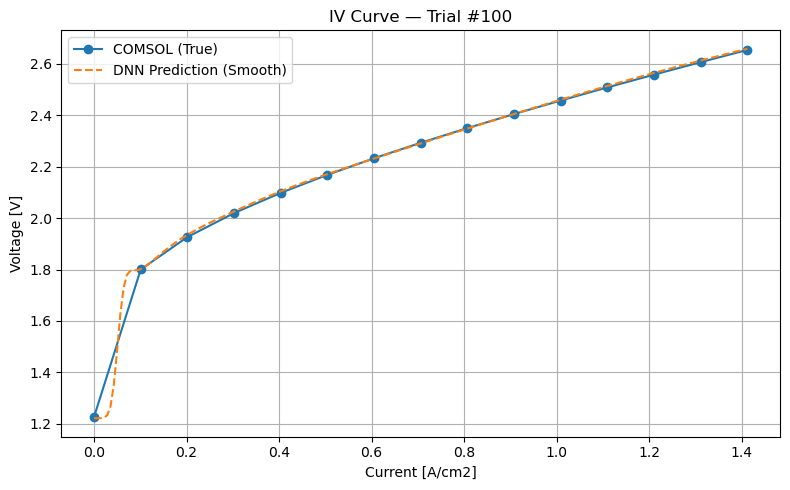

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(trial_df["Time_s"]/10, trial_df["Voltage_V"], label="COMSOL (True)", marker="o")
plt.plot(current_range/10, y_pred, label="DNN Prediction (Smooth)", linestyle="--")
plt.xlabel("Current [A/cm2]")
plt.ylabel("Voltage [V]")
plt.title(f"IV Curve — Trial #{trial_index}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
